In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

import re
import time
import pyodbc
from collections import OrderedDict

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [2]:
#data_r = pd.read_csv("RFM R.txt", sep='\t', names=['id', 'rfm_r'])
#data_f = pd.read_csv("RFM F.txt", sep='\t', names=['id', 'rfm_f'])
#data_m = pd.read_csv("RFM M.txt", sep='\t', names=['id', 'rfm_m'])

In [3]:
"""
def to_float(row):
    row['rfm_m'] = re.sub(r',', r'.', row['rfm_m'])
    return row
    
data = data.apply(to_float, axis=1)
""";

In [5]:
def get_rfm_query(typ, count=1000):
    query = """
            select {top} c.Id CustId
                ,{field}

                from directcrm.Customers c
                    join directcrm.CustomerActions ca on c.Id = ca.CustomerId
                    join directcrm.RetailOrders ro on ca.Id = ro.FirstCustomerActionId
                    join directcrm.RetailOrderHistory roh on ro.Id = roh.OrderId
                    join directcrm.RetailPurchaseHistory rph on roh.id = rph.OrderHistoryItemId
                    join directcrm.RetailPurchaseStatuses rps on rph.StatusId = rps.Id

                where rps.CategorySystemName not in ('Returned','Cancelled','InCart') and roh.IsCurrentOtherwiseNull = 1

                group by c.Id

                order by c.Id
            """
    
    fields = {'r': 'DateDiff(hh, Max(ca.DateTimeUtc), GetDate()) Recency_hours',
              'f': 'Count(ca.Id) CountActions',
              'm': 'Sum(roh.EffectivePayedAmount) Amount'}
    
    top = ''
    if count is not None:
        top = "top({})".format(count)
    
    query = query.format(top=top, field=fields[typ])
    return query

In [6]:
def get_rfm_data(cnxn, typ, count=1000):
    cursor = cnxn.cursor()
    cursor.execute(get_rfm_query(typ, count))
    rows = list(map(lambda t: [t[0], t[1]], cursor.fetchall()))
    df = pd.DataFrame(rows, columns=['id', 'rfm_{}'.format(typ)])
    return df

In [77]:
count = 100
data_test = get_rfm_data(cnxn, 'r', count=count)

ProgrammingError: Attempt to use a closed connection.

In [73]:
def get_full_rfm_data(count = 100) 
    cnxn = pyodbc.connect(driver='{SQL Server}',
                          server='aurora',
                          database='hoff')
    data_r = get_rfm_data(cnxn, 'r', count=count)
    data_f = get_rfm_data(cnxn, 'f', count=count)
    data_m = get_rfm_data(cnxn, 'm', count=count)
    cnxn.close()
return data_r, data_f, data_m

ProgrammingError: Attempt to use a closed connection.

In [8]:
if sum (data_r.id != data_f.id) or sum(data_r.id != data_m.id):
    raise RuntimeError("Не совпадают индексы")
else:
    data = pd.concat([data_r, data_f.drop('id', axis=1), data_m.drop('id', axis=1)], axis=1)

In [9]:
data.dtypes

id        int64
rfm_r     int64
rfm_f     int64
rfm_m    object
dtype: object

In [10]:
data['rfm_m'] = data['rfm_m'].astype(float)

In [11]:
data.head()

,id,rfm_r,rfm_f,rfm_m
0,5,33599,2,21960.0
1,149,33743,3,26750.0
2,221,21262,6,80022.0
3,293,27118,3,95950.0
4,294,27790,5,44380.0


In [12]:
data.shape

(10000, 4)

In [13]:
def reduce_tails(data, min_q=0.025, max_q=0.975):
    filtered_data = data[(data['rfm_r'] >= data['rfm_r'].quantile(min_q)) &
                         (data['rfm_r'] <= data['rfm_r'].quantile(max_q)) &
                         (data['rfm_f'] >= data['rfm_f'].quantile(min_q)) &
                         (data['rfm_f'] <= data['rfm_f'].quantile(max_q)) &
                         (data['rfm_m'] >= data['rfm_m'].quantile(min_q)) &
                         (data['rfm_m'] <= data['rfm_m'].quantile(max_q))]
    return filtered_data

In [14]:
raw_data = data.copy()

In [15]:
def draw_3d_plot(data, labels=None):
    fig = plt.figure()
    ax = Axes3D(fig)
    
    ax.set_xlabel("R")
    ax.set_ylabel("F")
    ax.set_zlabel("M")
    
    if labels is None:
        x = list(data['rfm_r'])
        y = list(data['rfm_f'])
        z = list(data['rfm_m'])
        ax.scatter(x, y, z)
        
    else:
        for n in np.unique(labels):
            indices = kmeans.labels_ == n
            x = list(data.loc[indices, 'rfm_r'])
            y = list(data.loc[indices, 'rfm_f'])
            z = list(data.loc[indices, 'rfm_m'])

            c = [[n * 2 % 256, n * 5 % 256, n * 13 % 256]]
            ax.scatter(x, y, z)

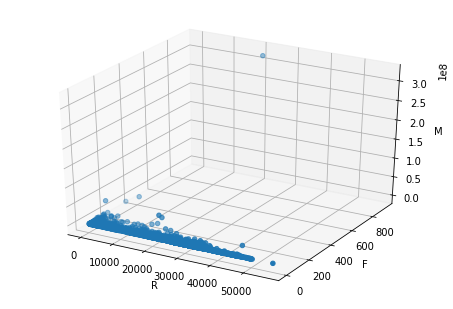

In [16]:
draw_3d_plot(data)

In [17]:
%%time
reduced_data = reduce_tails(data, 0.001, 0.999)

Wall time: 6 ms


Wall time: 36.5 ms


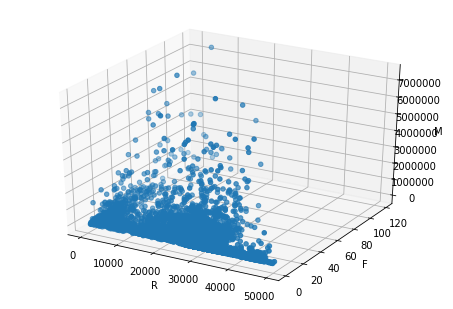

In [19]:
%%time
draw_3d_plot(reduced_data)

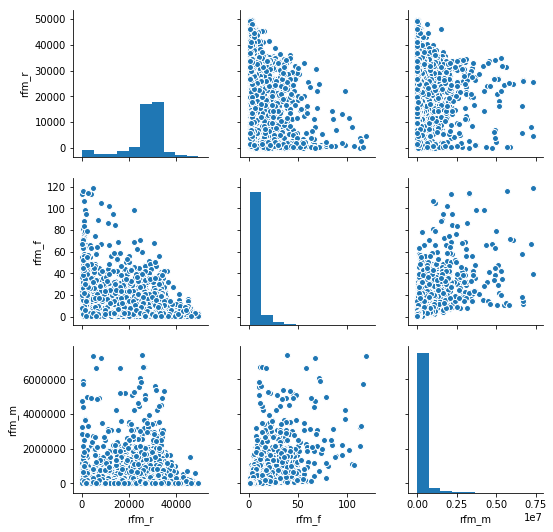

In [21]:
sns.pairplot(reduced_data.drop('id', axis=1))

In [23]:
data = reduced_data
X = data[['rfm_r', 'rfm_f', 'rfm_m']]

In [55]:
n_clusters = 12

In [56]:
kmeans = KMeans(n_clusters=n_clusters, random_state=17).fit(X)

In [57]:
kmeans.labels_
kmeans.cluster_centers_
kmeans.inertia_

26089790996397.46

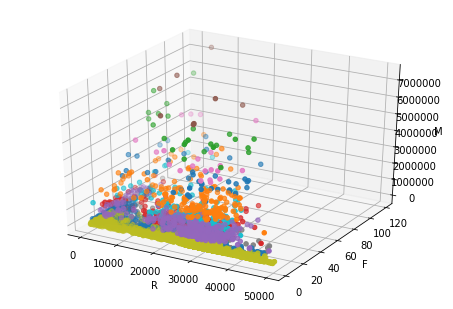

In [58]:
draw_3d_plot(X, kmeans.labels_)

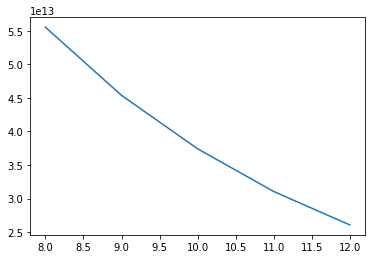

In [31]:
inertias = OrderedDict()
for n_clusters in range(8, 12 + 1):
    inertias[n_clusters] = KMeans(n_clusters=n_clusters, random_state=17).fit(X).inertia_
plt.plot(inertias.keys(), inertias.values())

In [82]:
cnxn.close()

ProgrammingError: Attempt to use a closed connection.

In [63]:
X_scaled = pd.DataFrame(StandardScaler().fit_transform(X), columns=X.columns)

In [64]:
kmeans_scaled = KMeans(n_clusters=n_clusters, random_state=17).fit(X_scaled)

In [65]:
kmeans_scaled.inertia_

3908.0737209780714

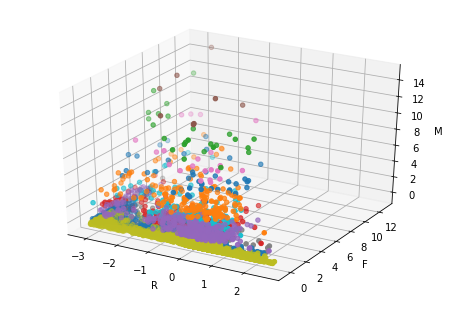

In [66]:
draw_3d_plot(X_scaled, kmeans_scaled.labels_)

In [67]:
sum(kmeans.labels_ != kmeans_scaled.labels_)

8966

In [68]:
kmeans.labels_[:30]

array([ 8,  8,  0,  0,  8,  8,  8,  0,  8,  8,  7,  8,  8,  3,  4,  7,  8,
        8,  8, 11,  8,  0,  8,  8,  7,  8,  9,  8,  8,  8])

In [69]:
kmeans_scaled.labels_[:30]

array([ 4,  4,  7,  0,  0,  0,  7,  0,  4,  4, 10,  0,  0,  7,  7, 10,  0,
        4,  0,  2,  0, 11,  4,  4, 10,  4,  5,  4,  4,  7])

In [85]:
l = kmeans.labels_
np.unique(l)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])